# IRC Behavioral Analysis

### Imports

In [3]:
import zat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from zat.log_to_dataframe import LogToDataFrame
from zat.bro_log_reader import BroLogReader
from collections import defaultdict
from textblob import TextBlob
import pycountry
from collections import defaultdict
from itertools import chain
import re
import itertools
from Levenshtein import distance as levenshtein_distance
from multiprocessing import Pool

## Loading Data

In [4]:
import os

log_names_mal = ['03','04','34','39','42','51','56','62']
log_names_benign = ['irc1']
log_names = log_names_mal + log_names_benign

project_dir = '/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/'
# project_dir = '/home/prenek/IRC-Behavioral-Analysis/'
log_dir = os.path.join(project_dir, 'zeek/logs/')
out_dir = os.path.join(project_dir, 'python/out/')

fileout_join_freq = 'join_freq.log'
fileout_lev_dist = 'lev_dist.log'

logs_fn_join = [os.path.join(log_dir,l,'irc_join.log') for l in log_names]
logs_fn_join_mal = [os.path.join(log_dir,l,'irc_join.log') for l in log_names_mal]
logs_fn_join_benign = [os.path.join(log_dir,l,'irc_join.log') for l in log_names_mal]

logs_fn_privmsg = [os.path.join(log_dir,l,'irc_privmsg.log') for l in log_names]
logs_fn_privmsg_mal = [os.path.join(log_dir,l,'irc_privmsg.log') for l in log_names_mal]
logs_fn_privmsg_benign = [os.path.join(log_dir,l,'irc_privmsg.log') for l in log_names_benign]

logs_fn_channelinfo = [os.path.join(log_dir,l,'irc_channelinfo.log') for l in log_names]
logs_fn_channelinfo_mal = [os.path.join(log_dir,l,'irc_channelinfo.log') for l in log_names_mal]
logs_fn_channelinfo_benign = [os.path.join(log_dir,l,'irc_channelinfo.log') for l in log_names_benign]

logs_fn_networkinfo = [os.path.join(log_dir,l,'irc_networkinfo.log') for l in log_names]
logs_fn_networkinfo_mal = [os.path.join(log_dir,l,'irc_networkinfo.log') for l in log_names_mal]
logs_fn_networkinfo_benign = [os.path.join(log_dir,l,'irc_networkinfo.log') for l in log_names_benign]

In [5]:
def load_logs(file):
    logs_arr = []
    if not os.path.isfile(file):
        return logs_arr
    
    reader = BroLogReader(file)
    for log in reader.readrows():
        # log is in dictionary format
        logs_arr.append(log)

    return logs_arr

In [6]:
logs_join_mal = list(map(lambda x: load_logs(x),logs_fn_join))
logs_join_benign = list(map(lambda x: load_logs(x),logs_fn_join))
logs_join = logs_join_mal + logs_join_benign

logs_privmsg_mal = list(map(lambda x: load_logs(x),logs_fn_privmsg_mal))
logs_privmsg_mal = [list(filter(lambda x: x['target'].startswith('#'), log)) for log in logs_privmsg_mal]
logs_privmsg_benign = list(map(lambda x: load_logs(x), logs_fn_privmsg_benign))
logs_privmsg_benign = [list(filter(lambda x: x['target'].startswith('#'), log)) for log in logs_privmsg_benign]
logs_privmsg = logs_privmsg_mal + logs_privmsg_benign

logs_channelinfo_mal = list(map(lambda x: load_logs(x), logs_fn_channelinfo_mal))
logs_channelinfo_benign = list(map(lambda x: load_logs(x), logs_fn_channelinfo_benign))
logs_channelinfo = logs_channelinfo_mal + logs_channelinfo_benign


logs_networkinfo_mal = list(map(lambda x: load_logs(x), logs_fn_networkinfo_mal))
logs_networkinfo_benign = list(map(lambda x: load_logs(x), logs_fn_networkinfo_benign))
logs_networkinfo = logs_networkinfo_mal + logs_networkinfo_benign

Successfully monitoring /Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/zeek/logs/04/irc_join.log...
Successfully monitoring /Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/zeek/logs/34/irc_join.log...
Successfully monitoring /Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/zeek/logs/39/irc_join.log...
Successfully monitoring /Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/zeek/logs/42/irc_join.log...
Successfully monitoring /Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/zeek/logs/51/irc_join.log...
Successfully monitoring /Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/zeek/logs/56/irc_join.log...
Successfully monitoring /Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/zeek/logs/62/irc_join.log...
Successfully monitoring /Users/preneond/Documents/Work/Stratos

### Divide logs by channels

In [7]:
from collections import defaultdict
logs_join_divided = []
for logs in logs_join:
    logs_per_channel = defaultdict(lambda: [])    
    for log in logs:
        logs_per_channel[log['channel']].append(log)
    logs_join_divided.append(logs_per_channel)

In [8]:
logs_privmsg_benign_divided = []
for logs in logs_privmsg_benign:
    logs_per_channel = defaultdict(lambda: [])    
    for log in logs:
        logs_per_channel[log['target']].append(log)
    logs_privmsg_benign_divided.append(logs_per_channel)

In [9]:
logs_privmsg_mal_divided = []
for logs in logs_privmsg_mal:
    logs_per_channel = defaultdict(lambda: [])    
    for log in logs:
        logs_per_channel[log['target']].append(log)
    logs_privmsg_mal_divided.append(logs_per_channel)

## Number of Users in Channel per Day

In [23]:
import json

def ircjoin_compute(logs):
    if len(logs) == 0:
        return None, None

    logs_ts = list(map(lambda x: x['ts'].date(), logs))

    # first ts of join command
    ts_min = min(logs_ts)
    ts_max = max(logs_ts)
#     print('min date: {}, max date: {}'.format(ts_min, ts_max))
    span = ts_max - ts_min
    
    dates = [ts_min+timedelta(days=i) for i in range(span.days+1)]

    ## count how many join commands are in which day 
    logs_per_day = defaultdict(lambda: 0)
    for v in logs_ts:
        logs_per_day[v] += 1
    
    dates_count = []
    count = 0
    for d in dates:
        count += logs_per_day[d]
        dates_count.append(count)
    
    return dates, dates_count


def ircjoin_visualize(dates, dates_count):
    plt.bar(dates,dates_count)
    plt.show()

### Data export into CSV

In [24]:
print('ircjoin...')
for ln, l in zip(log_names, logs_join_divided):
   fn = os.path.join(out_dir, ln, fileout_join_freq)
   df_join = pd.DataFrame(columns=['channel','date','users_count'])
   
   for l_k in l.keys():
       log = l[l_k]
       d_arr, dc_arr = ircjoin_compute(log)
       # ircjoin_visualize(d, dc)
       for d, dc in zip(d_arr,dc_arr):
           df_join = df_join.append({'channel': l_k, 'date': d, 'users_count': dc}, ignore_index=True)
   
   print(fn)
   df_join.to_csv(fn, sep=';', encoding='utf-8')

ircjoin...
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/03/join_freq.log
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/04/join_freq.log
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/34/join_freq.log
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/39/join_freq.log
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/42/join_freq.log
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/51/join_freq.log
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/56/join_freq.log
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/62/join_freq.log
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/irc1/join_freq.log


### Reading exported all csv and merging it into one 

In [12]:
# print('ircjoin...')
# df_join = pd.DataFrame(columns=['channel','date','users_count', 'pcap', 'malicious'])
# for ln in log_names_mal:
#     fn = os.path.join(out_dir, ln, fileout_join_freq)
#     df_join_tmp = pd.read_csv(fn, sep=';', encoding='utf-8')
   
#     for i, df_el in df_join_tmp.iterrows():
#         df_join = df_join.append({'channel': df_el['channel'],
#                                   'date': df_el['date'],
#                                   'users_count': df_el['users_count'],
#                                   'pcap': ln,
#                                   'malicious': 1
#                                  }, ignore_index=True)
   
# for ln in log_names_benign:
#     fn = os.path.join(out_dir, ln, fileout_join_freq)
#     df_join_tmp = pd.read_csv(fn, sep=';', encoding='utf-8')
#     for i, df_el in df_join_tmp.iterrows():
#         df_join = df_join.append({'channel': df_el['channel'],
#                                       'date': df_el['date'],
#                                       'users_count': df_el['users_count'],
#                                       'pcap': ln,
#                                       'malicious': 0
#                                      }, ignore_index=True)

df_join = pd.read_csv(os.path.join(out_dir, 'join_freq_all.csv'))

## Levenshtein Distance of Messages in Channel

In [69]:
def compute_levenshtein_distance(logs_msg):
    combs = itertools.combinations(logs_msg, 2)
    dist_lev_arr = []
    for msg1, msg2 in combs:
        dist_lev_arr.append(levenshtein_distance(msg1,msg2))
        
#     return dt_lev_arr

### Bubble plot

In [70]:
n = len(logs_privmsg_divided)

print('ircprivmsg..')

def compute_lev_dist_per_channel(fn, l_k):
    print('channel: ', l_k)
    # compute levenshtein distance
    logs_msg = [log['msg'] for log in logs_div[l_k]]
    logs_lev_dist = compute_levenshtein_distance(logs_msg)
    # compute number of msg's senders per channel
    sources = set([log['source'] for log in logs_div[l_k]])
    print('sources: ', len(sources))

    df = pd.DataFrame([{'channel': l_k, 'num_sources': len(sources), 'lev_dist': logs_lev_dist}])
    

    if not os.path.isfile(fn):
        print('creating csv file....')
        df.to_csv(fn, header='column_names')
    else:
        print('csv file exists.')
        df.to_csv(fn, mode='a', header=False)

    return df


for ln, logs_div in zip(log_names_benign, logs_privmsg_divided):
    with Pool() as pool:
        fn = os.path.join(out_dir, ln, fileout_lev_dist)
        # loop through channels            
        data = pool.starmap(compute_lev_dist_per_channel, itertools.product([fn], logs_div.keys()))     

channel:  ##Summit
channel:  #Runz
channel:  #007
channel:  #kz
channel:  #all
channel:  #x
channel:  #root
channel:  #o


## Channel Language Recognition

In [10]:
## Create a text corpus for each file
def load_corpus(logs, pcap):
    corp_ch = set(filter(lambda x: len(x) > 2, chain.from_iterable(chain.from_iterable(map(lambda x: [re.findall(r"[a-zA-Z]+", w) for w in x['msg'].split()], logs)))))
    return corp_ch

## Malicious Samples

Compute message corpus per each channels

In [31]:
# logs_in = logs_privmsg_mal_divided
# load_corpus(logs_in)
corpus_df_mal = pd.DataFrame(columns=['pcap','corpus','lang'])
for ln, logs in zip(log_names_mal, logs_privmsg_mal_divided):
    for channel in logs.keys():
        corpus = load_corpus(logs[channel], ln)
        corpus_df_mal = corpus_df_mal.append({'pcap': ln, 'channel': channel, 'corpus': corpus}, ignore_index=True)

Detect languages

In [32]:
for i, c in corpus_df_mal.iterrows():
    pcap = c['pcap']
    text = " ".join(c['corpus'])
    lang = "Unidentified"
    if len(text) > 2:
        code = TextBlob(text).detect_language()
        lang = pycountry.languages.get(alpha_2=code).name
    corpus_df_mal.iloc[i]['lang'] =  lang

### Plotbar - channels

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

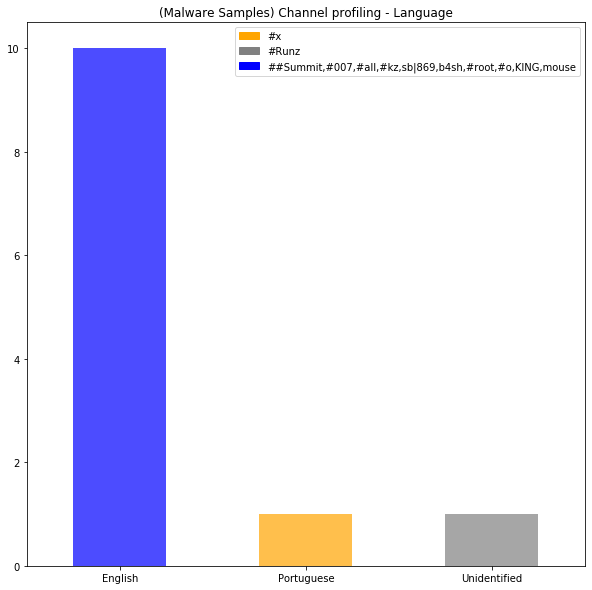

In [33]:
# # corpus_df.plot.pie(y='lang', figsize=(5,5))    
fig = plt.figure(figsize=(10,10))

myplot = corpus_df_mal['lang'].value_counts().plot(kind='bar', color =['blue','orange','gray'], title='(Malware Samples) Channel profiling - Language', alpha=0.7)
import matplotlib.patches as mpatches
POR = mpatches.Patch(color='orange', label= ",".join(list(corpus_df_mal[corpus_df_mal['lang'] == 'Portuguese']['channel'])))
UN = mpatches.Patch(color='gray', label= ",".join(list(corpus_df_mal[corpus_df_mal['lang'] == 'Unidentified']['channel'])))
ENG = mpatches.Patch(color='blue', label= ",".join(list(corpus_df_mal[corpus_df_mal['lang'] == 'English']['channel'])))
myplot.legend(handles=[POR,UN,ENG])

plt.xticks(rotation=0)

In [16]:
 corpus_df_mal['lang']

Series([], Name: lang, dtype: object)

### Plotbar - pcaps

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

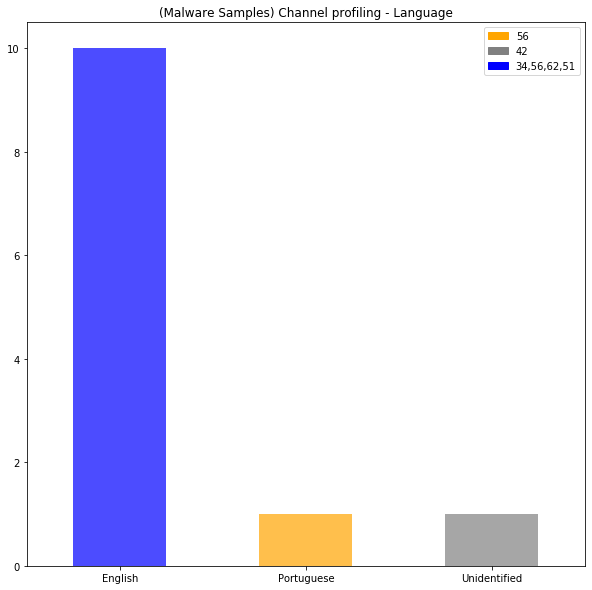

In [34]:
# # corpus_df.plot.pie(y='lang', figsize=(5,5))    
fig = plt.figure(figsize=(10,10))

myplot = corpus_df_mal['lang'].value_counts().plot(kind='bar', color =['blue','orange','gray'], title='(Malware Samples) Channel profiling - Language', alpha=0.7)
import matplotlib.patches as mpatches
POR = mpatches.Patch(color='orange', label= ",".join(set(corpus_df_mal[corpus_df_mal['lang'] == 'Portuguese']['pcap'])))
UN = mpatches.Patch(color='gray', label= ",".join(set(corpus_df_mal[corpus_df_mal['lang'] == 'Unidentified']['pcap'])))
ENG = mpatches.Patch(color='blue', label= ",".join(set(corpus_df_mal[corpus_df_mal['lang'] == 'English']['pcap'])))
myplot.legend(handles=[POR,UN,ENG])

plt.xticks(rotation=0)

## Benign Samples

Compute message corpus per each channels

In [35]:
corpus_df_benign = pd.DataFrame(columns=['pcap','corpus','lang'])
for ln, logs in zip(log_names_benign, logs_privmsg_benign_divided):
    for channel in logs.keys():
        corpus = load_corpus(logs[channel], ln)
        corpus_df_benign = corpus_df_benign.append({'pcap': ln, 'channel': channel, 'corpus': corpus}, ignore_index=True)

Detect language

In [36]:
for i, c in corpus_df_benign.iterrows():
    pcap = c['pcap']
    text = " ".join(c['corpus'])
    lang = "Unidentified"
    if len(text) > 2:
        code = TextBlob(text).detect_language()
        lang = pycountry.languages.get(alpha_2=code).name
    corpus_df_benign.iloc[i]['lang'] =  lang

### Plotbar - channels

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

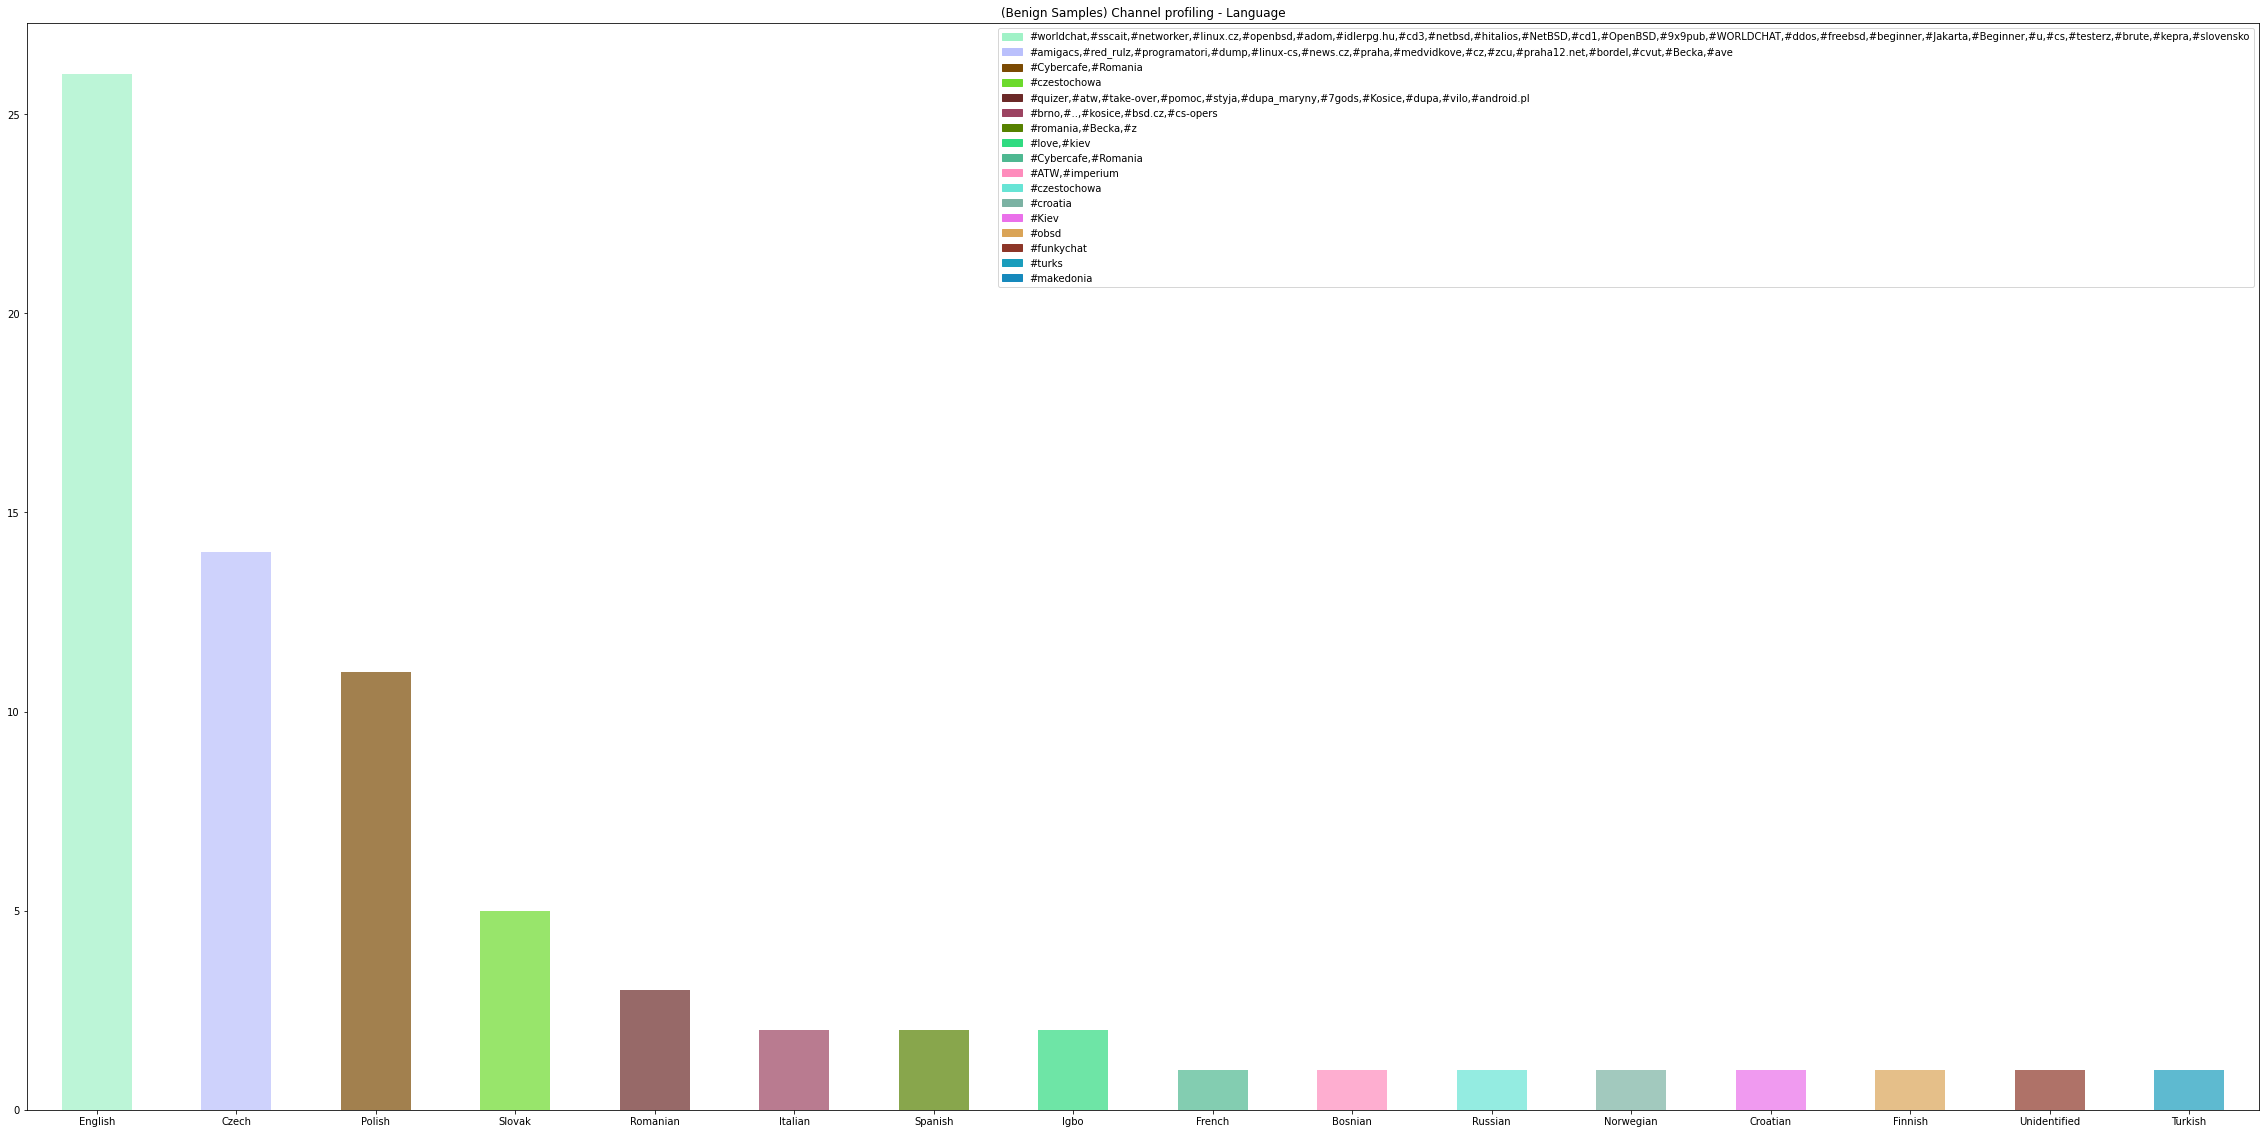

In [42]:
import random
# corpus_df.plot.pie(y='lang', figsize=(5,5))    
fig = plt.figure(figsize=(40,20))
rgb = [(random.random(), random.random(), random.random()) for i in range(corpus_df_benign.shape[0])]
langs = ['English', 'Czech', 'Spanish', 'French', 'Polish','Slovak',
         'Romanian', 'Italian', 'Spanish', 'Igbo', 'French','Bosnian',
         'Russian', 'Norwegian', 'Finnish', 'Turkish', 'Unidentified']
myplot = corpus_df_benign['lang'].value_counts().plot(kind='bar', color=rgb, title='(Benign Samples) Channel profiling - Language', alpha=0.7)
import matplotlib.patches as mpatches

handle_arr = []
for c, lang in zip(rgb, langs):
    h = mpatches.Patch(color=c, label= ",".join(list(corpus_df_benign[corpus_df_benign['lang'] == lang]['channel'])))
    handle_arr.append(h)

myplot.legend(handles=handle_arr)

plt.xticks(rotation=0)

### Plotbar - pcaps

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

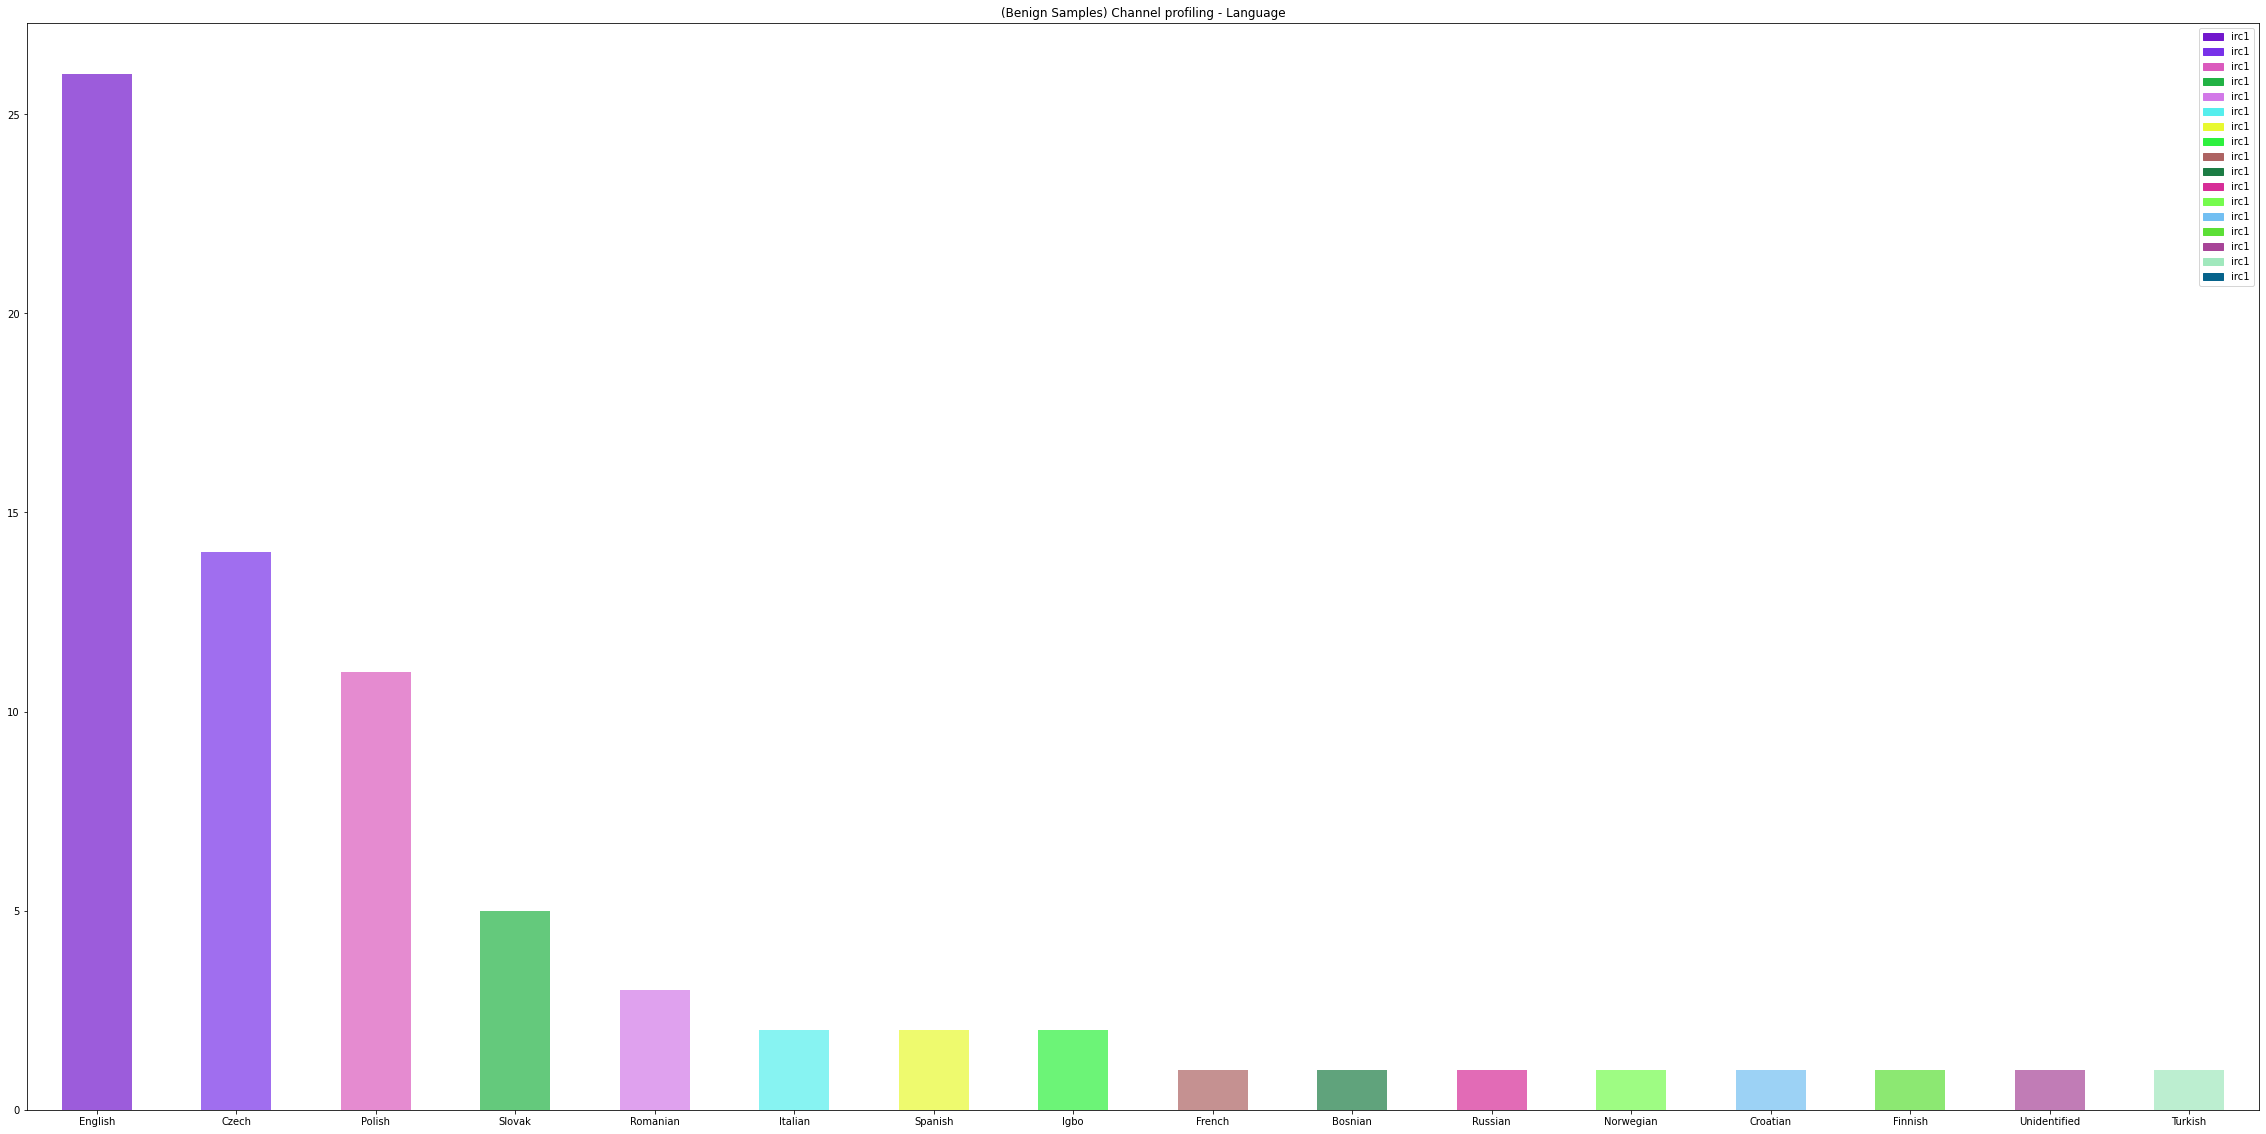

In [47]:
# corpus_df.plot.pie(y='lang', figsize=(5,5))    
fig = plt.figure(figsize=(40,20))
rgb = [(random.random(), random.random(), random.random()) for i in range(corpus_df_benign.shape[0])]
langs = ['English', 'Czech', 'Spanish', 'French', 'Polish','Slovak',
         'Romanian', 'Italian', 'Spanish', 'Igbo', 'French','Bosnian',
         'Russian', 'Norwegian', 'Finnish', 'Turkish', 'Unidentified']
myplot = corpus_df_benign['lang'].value_counts().plot(kind='bar', color=rgb, title='(Benign Samples) Channel profiling - Language', alpha=0.7)
import matplotlib.patches as mpatches

handle_arr = []
for c, lang in zip(rgb, langs):
    h = mpatches.Patch(color=c, label= ",".join(set(corpus_df_benign[corpus_df_benign['lang'] == lang]['pcap'])))
    handle_arr.append(h)

myplot.legend(handles=handle_arr)

plt.xticks(rotation=0)

## Message periodicity

In [10]:
def compute_channel_periodicity(communication):
    """
    using Fast Fourier Transform to compute periodicity of messages in sessions
    @:return value in [0,1] interval - 0 means that messages are not periodic at all
    """

    if len(communication) < 3:
        return None

    t = list(map(lambda x: x['ts'].timestamp(), communication))
    td = np.asarray(list(map(lambda x: x[0] - x[1], zip(t[1:], t))))
    fft_res = np.absolute(np.fft.fft(td))
    T = fft_res.argmax() + 2

    rng_size = int(len(td) / T)
    td_T = [td[x * T:x * T + T] for x in range(rng_size)]
    td_T_avg = np.mean(td_T, 0)
    # ||td_t - td_avg ||2 / ||td_t||
    td_nmse = np.linalg.norm(td_T - td_T_avg) / np.linalg.norm(td_T)

    return 1 - td_nmse

### Malicious samples

In [11]:
for ln, logs in zip(log_names_mal, logs_privmsg_mal_divided):
    for channel in logs.keys():
        print(channel)
        print(compute_channel_periodicity(logs[channel]))

##Summit
0.015128429132320709
#Runz
None
#007
0.02555968508219897
#all
0.0021900108768839743
#kz
nan
sb|869
nan
b4sh
nan
#x
0.057190958417936644
#root
0.04653741075440776
#o
0.07417990022744858
KING
nan
mouse
nan


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


### Benign Samples

In [12]:
for ln, logs in zip(log_names_benign, logs_privmsg_benign_divided):
    for channel in logs.keys():
        print(channel)
        print(compute_channel_periodicity(logs[channel]))

#worldchat
0.012570744138649781
#amigacs
0.00861610081441666
#sscait
0.4345393472631347
#networker
1.0
#red_rulz
0.0035106419700695612
#linux.cz
0.2873885829314331
#programatori
1.0
#brno
1.0
#dump
1.0
#quizer
0.24467197294145826
#atw
0.006827159800756544
#take-over
0.2875453315696175
#linux-cs
1.0
#openbsd
0.03012012034606537
#pomoc
0.019457959199807084
#love
0.004836489272078914
#Kiev
0.0029509823022598747
#news.cz
1.0
#praha
1.0
#medvidkove
0.005605784033985262
#adom
0.006609704412341655
#cz
0.013359640721099075
#idlerpg.hu
0.006249288752290472
#Cybercafe
0.301376285935927
#styja
0.021993537965344645
#cd3
0.3029786384898373
#netbsd
1.0
#hitalios
None
#NetBSD
0.13397459611396056
#cd1
0.7050974114494748
#zcu
0.006045403428441842
#romania
0.04449966524875626
#OpenBSD
0.3265374778651732
#9x9pub
0.21012288703085658
#WORLDCHAT
0.05321232456894831
#ddos
0.05370655754594733
#kiev
0.2928932188134524
#freebsd
0.1840367923279057
#beginner
0.10423973523933094
#Jakarta
None
#ATW
0.43841028402962

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


## Message Frequency

In [48]:
def get_message_frequency(logs):
    if len(logs) < 2:
        return 0.0
    t = list(map(lambda x: x['ts'].timestamp(), logs))
    try:
        return len(t)/(t[-1]-t[0])
    except ZeroDivisionError:
        return 0.0

### Malicious Samples

In [49]:
for ln, logs in zip(log_names_mal, logs_privmsg_mal_divided):
    for channel in logs.keys():
        print(channel)
        print(get_message_frequency(logs[channel]))

##Summit
0.0014494471828811499
#Runz
0.0
#007
0.00018943037592731668
#all
0.002409201303405292
#kz
0.0
sb|869
0.0
b4sh
0.0
#x
0.000963526035675216
#root
0.000257174949286345
#o
146.19903098748648
KING
0.0
mouse
0.0


### Benign Samples

In [50]:
for ln, logs in zip(log_names_benign, logs_privmsg_benign_divided):
    for channel in logs.keys():
        print(channel)
        print(get_message_frequency(logs[channel]))

#worldchat
0.022352735250257022
#amigacs
0.0011944242986728355
#sscait
6.470790986247647e-05
#networker
0.013756798163160023
#red_rulz
0.003069545632393971
#linux.cz
0.0023971979016283
#programatori
0.03180945775457946
#brno
0.0010897298877341674
#dump
0.017035960812017567
#quizer
0.0012421726749749424
#atw
0.005027228262539666
#take-over
0.0042949980592091345
#linux-cs
0.042151712783795064
#openbsd
0.001252340856882569
#pomoc
0.0010530725533292092
#love
0.0036715965586053847
#Kiev
0.002100235022941908
#news.cz
0.07590024291436934
#praha
0.0034615808989798967
#medvidkove
0.005069127305972177
#adom
0.002365986178268756
#cz
0.0011214937834661321
#idlerpg.hu
0.0009093772328374456
#Cybercafe
2.9095509158203607e-05
#styja
0.00029509526626130347
#cd3
3.536329383069081e-05
#netbsd
0.0006642293393409727
#hitalios
0.0
#NetBSD
7.811713220239137e-05
#cd1
0.00040458922689056413
#zcu
0.0014699335199836359
#romania
0.00015809733601533806
#OpenBSD
0.00023578008277875547
#9x9pub
4.3569043810178334e-05

## Special characters

In [25]:
def get_spec_chars_mean(logs):
    word_ch = list(chain.from_iterable(map(lambda x: x['msg'].split(), logs)))
    word_spec = map(lambda x: "".join(re.findall(r'[^A-Za-z]',x)), word_ch)
    spec_chars_count = sum(map(len, word_spec))
    chars_total_count = sum(map(len, word_ch))
    return spec_chars_count/chars_total_count

### Malicous Samples

In [21]:
for ln, logs in zip(log_names_mal, logs_privmsg_mal_divided):
    for channel in logs.keys():
        m = get_spec_chars_mean(logs[channel])
        print(channel)
        print(m)

'#@$%#$%$78897981290490248'

### Benign Samples

In [26]:
for ln, logs in zip(log_names_benign, logs_privmsg_benign_divided):
    for channel in logs.keys():
        m = get_spec_chars_mean(logs[channel])
        print(channel)
        print(m)

#worldchat
0.0894181388919718
#amigacs
0.17476033317617476
#sscait
0.09375
#networker
0.07656931804811672
#red_rulz
0.08970024791525806
#linux.cz
0.220095633730343
#programatori
0.14638966245807064
#brno
0.14609861826063397
#dump
0.1251922946679954
#quizer
0.2048705413724425
#atw
0.16654117140859465
#take-over
0.19739558519930125
#linux-cs
0.13163620539599652
#openbsd
0.12412017167381974
#pomoc
0.21441450221724087
#love
0.14161211129296236
#Kiev
0.10324200576028358
#news.cz
0.22402361869308193
#praha
0.35988032483259724
#medvidkove
0.1419194790428446
#adom
0.05653163404642694
#cz
0.08014212396367944
#idlerpg.hu
0.24967106994368718
#Cybercafe
0.1388888888888889
#styja
0.3595238095238095
#cd3
0.27450980392156865
#netbsd
0.10693069306930693
#hitalios
0.3333333333333333
#NetBSD
0.02962962962962963
#cd1
0.3333333333333333
#zcu
0.05611271765212576
#romania
0.15025906735751296
#OpenBSD
0.3214814814814815
#9x9pub
0.0
#WORLDCHAT
0.05314009661835749
#ddos
0.14285714285714285
#kiev
0.0
#freebsd
0

## Word entropy

In [37]:
def get_word_entropy(logs):
    msg_word_count = defaultdict(lambda : 0)
    comm2 = []
    for log in logs:
        msg_words = log['msg'].split()
        for word in msg_words:
            msg_word_count[word] += 1

    _wordcounts = list(msg_word_count.values())
    p = _wordcounts / np.sum(_wordcounts)
    msg_word_entropy = -np.sum(p * np.log2(p))
    return msg_word_entropy

### Malicous Samples

In [39]:
for ln, logs in zip(log_names_mal, logs_privmsg_mal_divided):
    for channel in logs.keys():
        m = get_word_entropy(logs[channel])
        print(channel)
        print(m)

##Summit
8.10370868691142
#Runz
-0.0
#007
4.820940114626764
#all
4.278526261638936
#kz
5.244205515288646
sb|869
3.8268748818646374
b4sh
6.671548299795974
#x
5.0282456488610165
#root
5.824297280597514
#o
4.404315949407467
KING
3.846439344671016
mouse
3.846439344671016


### Benign Samples

In [38]:
for ln, logs in zip(log_names_benign, logs_privmsg_benign_divided):
    for channel in logs.keys():
        m = get_word_entropy(logs[channel])
        print(channel)
        print(m)

#worldchat
10.524316276910755
#amigacs
10.192377367425077
#sscait
4.6371987351738495
#networker
10.312721393626589
#red_rulz
9.23285661635769
#linux.cz
8.671442225939298
#programatori
11.541128438212413
#brno
8.475776064843428
#dump
10.30338190346369
#quizer
8.031681207992133
#atw
10.078145864688882
#take-over
8.73021043097653
#linux-cs
10.210444947937189
#openbsd
9.049965232513713
#pomoc
9.679540491364456
#love
7.4729285467619695
#Kiev
9.336393542497646
#news.cz
12.463609748199161
#praha
8.852557095049475
#medvidkove
10.404932457353208
#adom
9.513288444344287
#cz
8.036281869041405
#idlerpg.hu
7.75138360098888
#Cybercafe
1.3787834934861753
#styja
5.916866755464442
#cd3
1.5916727785823275
#netbsd
8.065177810108096
#hitalios
1.0
#NetBSD
5.585816304394414
#cd1
1.0
#zcu
9.39732485258433
#romania
5.0721401598021085
#OpenBSD
3.169925001442312
#9x9pub
0.9709505944546686
#WORLDCHAT
5.4403617589398685
#ddos
3.180832987205441
#kiev
2.4193819456463714
#freebsd
4.1757358691004915
#beginner
3.85827

## Channel - Active Users

In [15]:
def get_active_users(logs):
    active_users = set(map(lambda x: x['source'], logs))
    return len(active_users)

### Malicous Samples

In [18]:
for ln, logs in zip(log_names_mal, logs_privmsg_mal_divided):
    for channel in logs.keys():
        m = get_active_users(logs[channel])
        print(channel)
        print(m)

##Summit
6
#Runz
1
#007
3
#all
4
#kz
2
#x
5
#root
6
#o
4


### Benign Samples

In [16]:
for ln, logs in zip(log_names_benign, logs_privmsg_benign_divided):
    for channel in logs.keys():
        m = get_active_users(logs[channel])
        print(channel)
        print(m)

#worldchat
201
#amigacs
6
#sscait
1
#networker
70
#red_rulz
11
#linux.cz
1
#programatori
38
#brno
10
#dump
13
#quizer
5
#atw
40
#take-over
26
#linux-cs
19
#openbsd
14
#pomoc
8
#love
13
#Kiev
9
#news.cz
24
#praha
11
#medvidkove
12
#adom
17
#cz
10
#idlerpg.hu
1
#Cybercafe
4
#styja
4
#cd3
1
#netbsd
10
#hitalios
1
#NetBSD
2
#cd1
1
#zcu
5
#romania
7
#OpenBSD
1
#9x9pub
1
#WORLDCHAT
1
#ddos
3
#kiev
1
#freebsd
5
#beginner
5
#Jakarta
1
#ATW
1
#turks
2
#Beginner
2
#..
5
#dupa_maryny
3
#kosice
2
#obsd
2
#Becka
1
#u
1
#7gods
1
#Kosice
2
#dupa
2
#cs
6
#vilo
5
#praha12.net
1
#testerz
1
#android.pl
4
#brute
3
#kepra
1
#bsd.cz
1
#imperium
4
#bordel
2
#cs-opers
2
#orava
2
#croatia
3
#cvut
4
#Becka,#ave
1
#slovensko
1
#czestochowa
1
#Romania
1
#funkychat
1
#z
1
#makedonia
1


## Network Info - Number of Services

In [1]:
def get_num_services(logs):
    try:
        num_services = list(map(lambda x: x['services'], logs))
        return max(num_services)
    except:
        return 0

### Malicious Samples

In [10]:
for ln, l in zip(log_names_mal, logs_networkinfo_mal):
    m = get_num_services(l)
    print(m)

0
0
0
0
0
0
0
0


### Benign Samples

In [11]:
for ln, l in zip(log_names_benign, logs_networkinfo_benign):
    m = get_num_services(l)
    print(m)

2


## Network Info - Number of Users

In [12]:
def get_num_users(logs):
    try:
        num_services = list(map(lambda x: x['users'], logs))
        return max(num_services)
    except:
        return 0

### Malicious Samples

In [13]:
for ln, l in zip(log_names_mal, logs_networkinfo_mal):
    m = get_num_users(l)
    print(m)

0
0
1
2462
233
1
2
75


### Benign Samples

In [14]:
for ln, l in zip(log_names_benign, logs_networkinfo_benign):
    m = get_num_users(l)
    print(m)

30316


## One-channel users Ratio

### Malicous Samples

### Benign Samples